## EDA - iDENTITY FEATURES

In [1]:
## Import Library 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# load merge data
DATA_DIR = Path('../data/interim')
train = pd.read_parquet(DATA_DIR / 'train_merged.parquet')

print(f'data loaded {train.shape[0]:,} row and {train.shape[1]:,} columns')

data loaded 590,540 row and 434 columns


In [2]:
train.columns.values

array(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1',
       'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29',
       'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38',
       'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56',
       'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65',
       'V66', 'V6

In [3]:
# identity coolumns
id_cols = [c for c in train.columns if c.startswith('id_')]
device_cols = ['DeviceType', 'DeviceInfo']

# check if any identity data exist per row
identity = train[id_cols + device_cols].notna().any(axis=1)

print('Identity Coverage')
print(f'Total Transacion : {len(train):,}')
print(f'   With identity: {identity.sum():,} ({identity.mean()*100:.1f}%)')
print(f'   Without identity: {(~identity).sum():,} ({(~identity).mean()*100:.1f}%)')

Identity Coverage
Total Transacion : 590,540
   With identity: 144,233 (24.4%)
   Without identity: 446,307 (75.6%)


Fraud Rate by identity presence
with identity : 7.85%
without identity : 2.09%


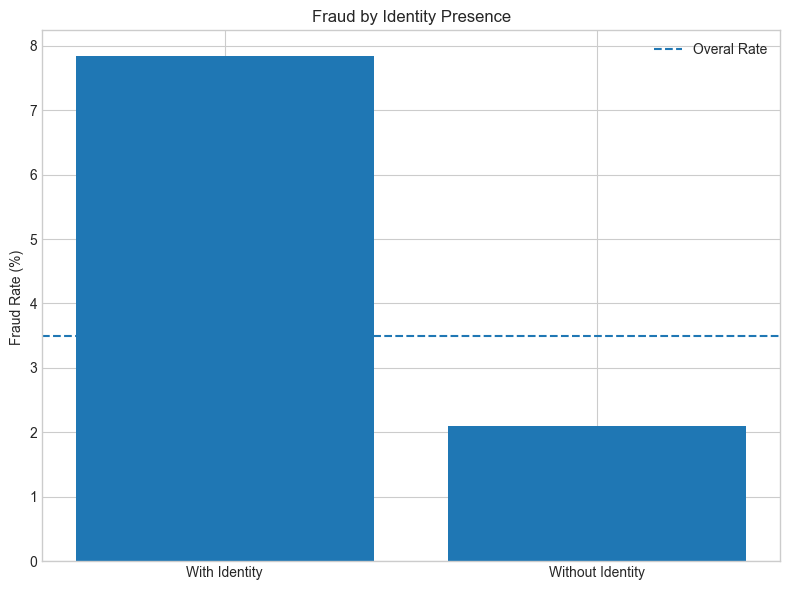

In [5]:
# fraud rate by identity presence

fraud_id = train.loc[identity, 'isFraud'].mean() * 100
fraud_without_id = train.loc[~identity, 'isFraud'].mean() * 100

print('Fraud Rate by identity presence')
print(f'with identity : {fraud_id:.2f}%')
print(f'without identity : {fraud_without_id:.2f}%')

# visualize 
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(['With Identity', 'Without Identity'], [fraud_id, fraud_without_id])
ax.set_ylabel('Fraud Rate (%) ')
ax.set_title('Fraud by Identity Presence')
ax.axhline(y=train['isFraud'].mean() * 100, linestyle='--', label='Overal Rate')
ax.legend()
plt.tight_layout()
plt.show()

## Device Feature 

In [8]:
## DEVICE TYPE
print('DeviceType Distribution :')
print(train['DeviceType'].value_counts(dropna=False))

# fraud by device type
device_fraud = train.groupby('DeviceType', dropna=False)['isFraud'].agg(['mean', 'count'])
device_fraud['mean'] *= 100

print('Fraud Rate by DeviceType:')
print(device_fraud)

DeviceType Distribution :
DeviceType
NaN        449730
desktop     85165
mobile      55645
Name: count, dtype: int64
Fraud Rate by DeviceType:
                 mean   count
DeviceType                   
desktop      6.521458   85165
mobile      10.166232   55645
NaN          2.101705  449730
